In [1]:
# here the update classficastion function
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import os


def EvaluateModel(y_test, y_pred, model_name):
    metrics = {
        "Accuracy": accuracy_score,
        "F1 Score": f1_score,
        "Precision": precision_score,
        "Recall": recall_score,
        "roc-auc": roc_auc_score,
    }
    eval_results = {"model": model_name}
    for metric, function in metrics.items():
        eval = function(y_test, y_pred)
        eval_results[metric] = eval
        print(metric, eval)
    return eval_results


def plotConfusionMatrix(y_test, y_pred, model_name, model_dir):
    # calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Death Prediction Confusion Matrix")
    plt.savefig(os.path.join(model_dir, f"{model_name}_confusion_matrix.png"))
    plt.show()
    plt.close()

In [58]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import os


def trainClassificationModel(X, y, model_dir, chunk=3, bagging=True):
    os.path.isdir(model_dir) or os.makedirs(model_dir)
    classification_models = [
        (
            "SVM",
            SVC(random_state=42),
            {
                "C": [1e-3, 1e-2, 1e-1, 1, 10],
                "kernel": ["linear", "rbf"],
                "gamma": ["scale", "auto"],
            },
        ),
        (
            "RF",
            RandomForestClassifier(random_state=42, n_jobs=-1),
            {
                "n_estimators": [50, 100, 200],
                "max_depth": [None, 10, 20, 30],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
            },
        ),
        # (
        #     "XGB",
        #     XGBClassifier(random_state=42, n_jobs=-1),
        #     {
        #         "n_estimators": [50, 100, 200],
        #         "max_depth": [3, 6, 9],
        #         "learning_rate": [0.01, 0.1, 0.2],
        #         "subsample": [0.8, 1.0],
        #         "colsample_bytree": [0.8, 1.0],
        #     },
        # ),
        # (
        #     "LGBM",
        #     LGBMClassifier(random_state=42, n_jobs=-1),
        #     {
        #         "n_estimators": [50, 100, 200],
        #         "max_depth": [3, 6, 9],
        #         "learning_rate": [0.01, 0.1, 0.2],
        #         "subsample": [0.8, 1.0],
        #         "colsample_bytree": [0.8, 1.0],
        #     },
        # ),
        (
            "KNN",
            KNeighborsClassifier(n_jobs=-1),
            {
                "n_neighbors": [3, 5, 7],
                "weights": ["uniform", "distance"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
            },
        ),
        (
            "ADA",
            AdaBoostClassifier(random_state=42),
            {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1, 1.0],
            },
        ),
    ]

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1121
    )
    results = []

    for name, model, param_grid in classification_models:
        print(f"Starting training for {name} with GridSearchCV...")
        grid_search = GridSearchCV(
            model, param_grid, cv=5, scoring="accuracy", n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        print(f"Best parameters for {name} are {best_params}")
        if bagging:
            best_model = BaggingClassifier(
                estimator=model.__init__(**best_params),
                n_estimators=100,
                random_state=42,
                max_features=1 / chunk,
                n_jobs=-1,
            )
            best_model.fit(X_train, y_train)
        else:
            best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        results.append(EvaluateModel(y_test, y_pred, name))
        plotConfusionMatrix(y_test, y_pred, name, model_dir)
        model_path = os.path.join(model_dir, name + ".pkl")
        with open(model_path, "wb") as f:
            pickle.dump(best_model, f)
    results = pd.DataFrame(results)
    results.to_csv(os.path.join(model_dir, "results.csv"), index=False)
    print("classification_models and results saved in {}".format(model_dir))

Starting training for SVM with GridSearchCV...
Best parameters for SVM are {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy 0.6875
F1 Score 0.7916666666666666
Precision 0.7037037037037037
Recall 0.9047619047619048
roc-auc 0.5887445887445888


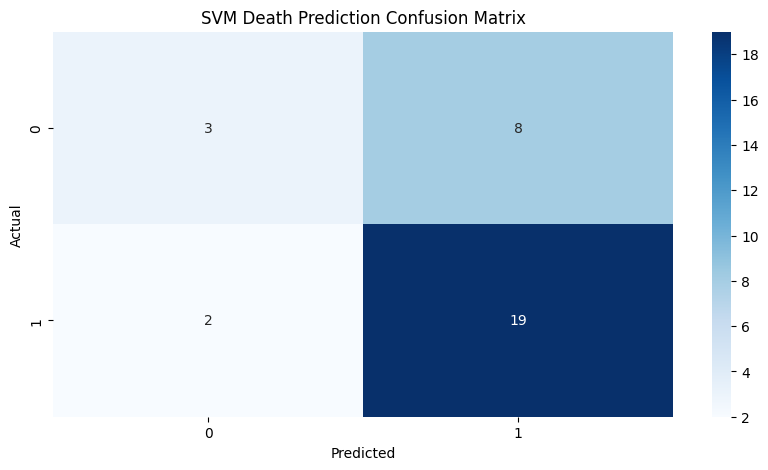

Starting training for RF with GridSearchCV...
Best parameters for RF are {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy 0.6875
F1 Score 0.7916666666666666
Precision 0.7037037037037037
Recall 0.9047619047619048
roc-auc 0.5887445887445888


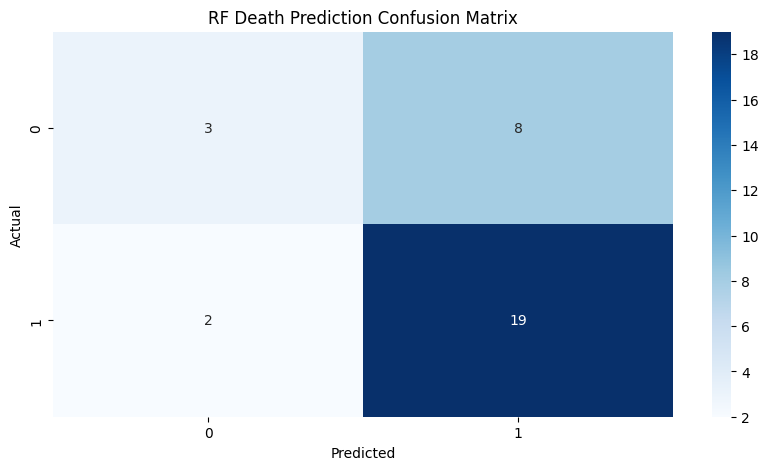

Starting training for KNN with GridSearchCV...
Best parameters for KNN are {'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'uniform'}
Accuracy 0.6875
F1 Score 0.7916666666666666
Precision 0.7037037037037037
Recall 0.9047619047619048
roc-auc 0.5887445887445888


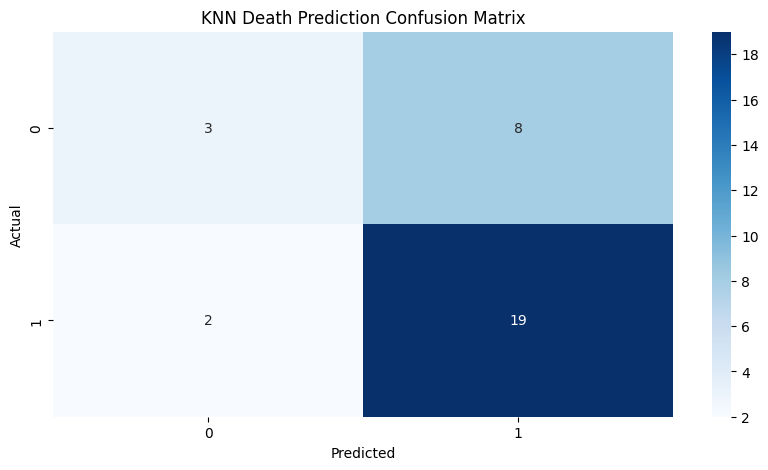

Starting training for ADA with GridSearchCV...
Best parameters for ADA are {'learning_rate': 0.1, 'n_estimators': 200}
Accuracy 0.6875
F1 Score 0.7916666666666666
Precision 0.7037037037037037
Recall 0.9047619047619048
roc-auc 0.5887445887445888


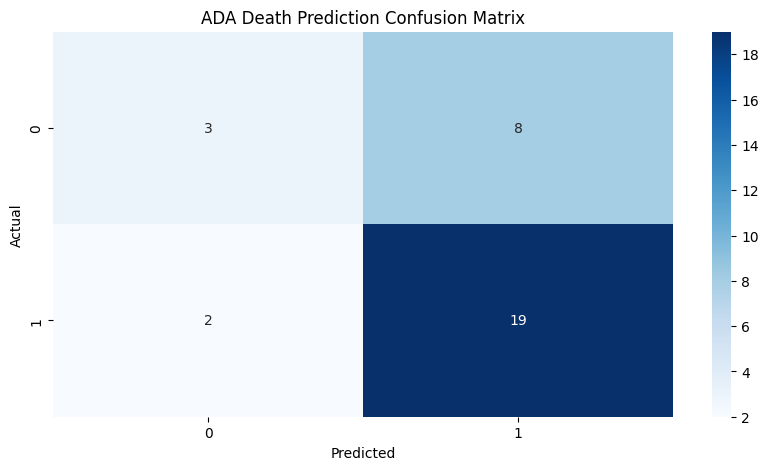

classification_models and results saved in ../models/raw-dataset/aml/


In [59]:
df = pd.read_csv("../dataset/processed/aml/final_data.csv")
df.dropna(inplace=True)
X = df.drop(
    # Split the dataset into features and target
    ["Survival", "Death"],
    axis=1,
    inplace=False,
)  # Assuming the first two columns are not features
y = df["Death"]  # Assuming the second column is the target
model_dir = "../models/raw-dataset/aml/"
trainClassificationModel(X, y, model_dir)

Starting training for SVM with GridSearchCV...
Best parameters for SVM are {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy 0.6875
F1 Score 0.8
Precision 0.7407407407407407
Recall 0.8695652173913043
roc-auc 0.5458937198067633


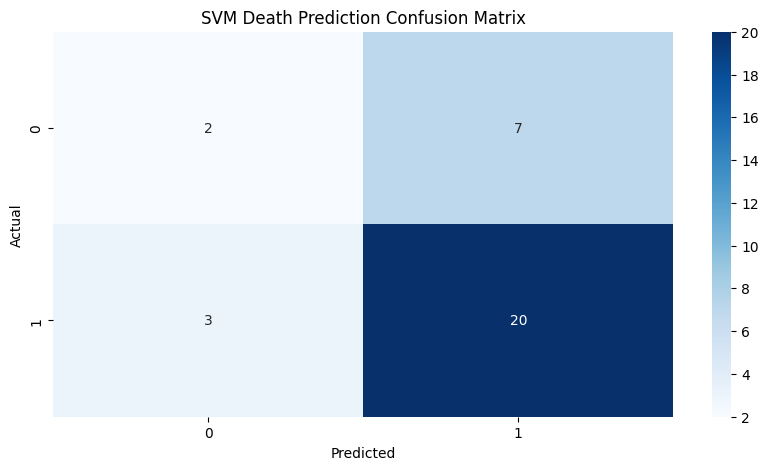

Starting training for RF with GridSearchCV...
Best parameters for RF are {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy 0.6875
F1 Score 0.8
Precision 0.7407407407407407
Recall 0.8695652173913043
roc-auc 0.5458937198067633


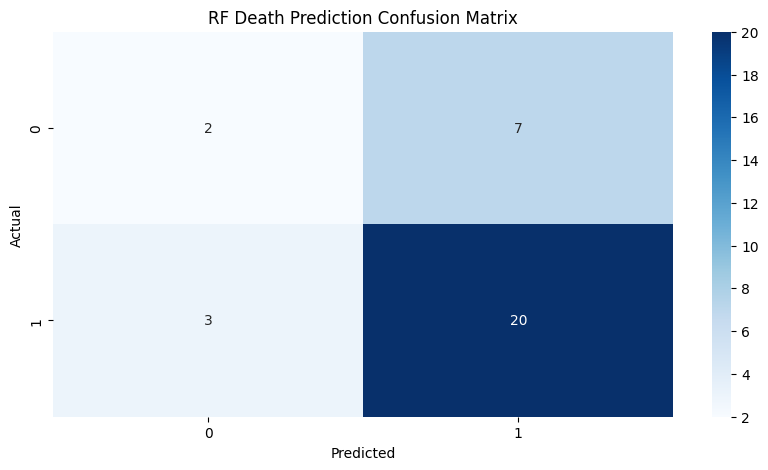

Starting training for KNN with GridSearchCV...
Best parameters for KNN are {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}
Accuracy 0.6875
F1 Score 0.8
Precision 0.7407407407407407
Recall 0.8695652173913043
roc-auc 0.5458937198067633


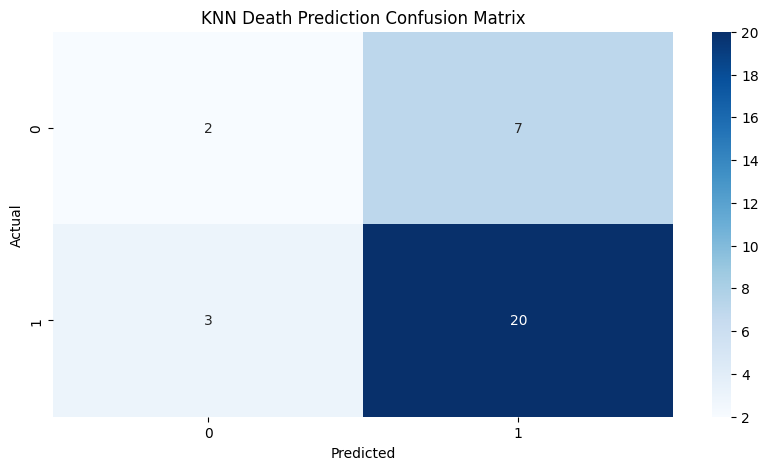

Starting training for ADA with GridSearchCV...
Best parameters for ADA are {'learning_rate': 0.01, 'n_estimators': 100}
Accuracy 0.6875
F1 Score 0.8
Precision 0.7407407407407407
Recall 0.8695652173913043
roc-auc 0.5458937198067633


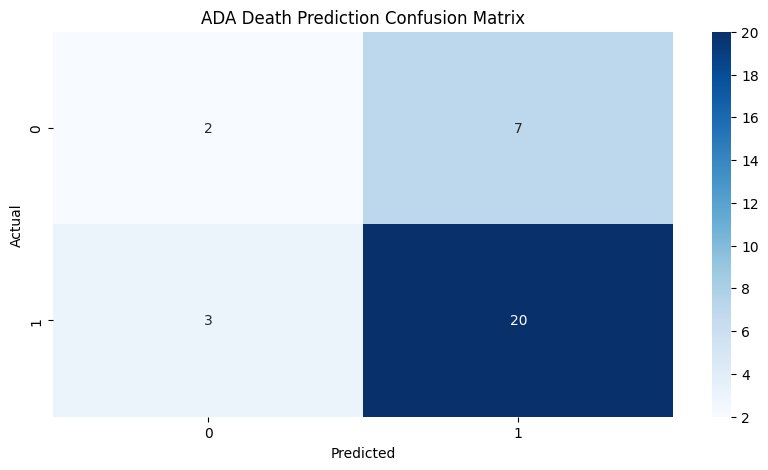

classification_models and results saved in ../models/bagging/aml/3-chunks
(159, 2306)
Starting training for SVM with GridSearchCV...
Best parameters for SVM are {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy 0.625
F1 Score 0.75
Precision 0.72
Recall 0.782608695652174
roc-auc 0.5024154589371981


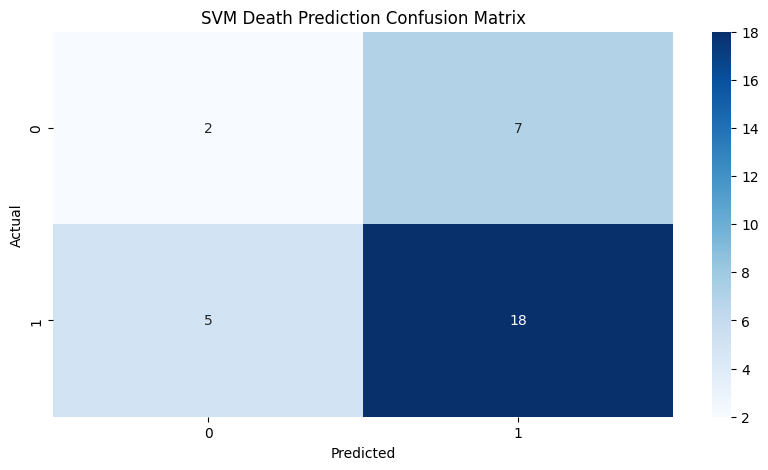

Starting training for RF with GridSearchCV...
Best parameters for RF are {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy 0.625
F1 Score 0.75
Precision 0.72
Recall 0.782608695652174
roc-auc 0.5024154589371981


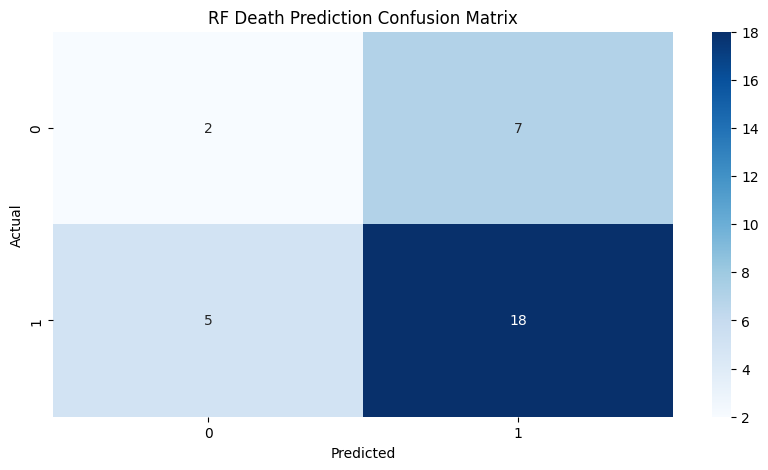

Starting training for KNN with GridSearchCV...
Best parameters for KNN are {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'uniform'}
Accuracy 0.625
F1 Score 0.75
Precision 0.72
Recall 0.782608695652174
roc-auc 0.5024154589371981


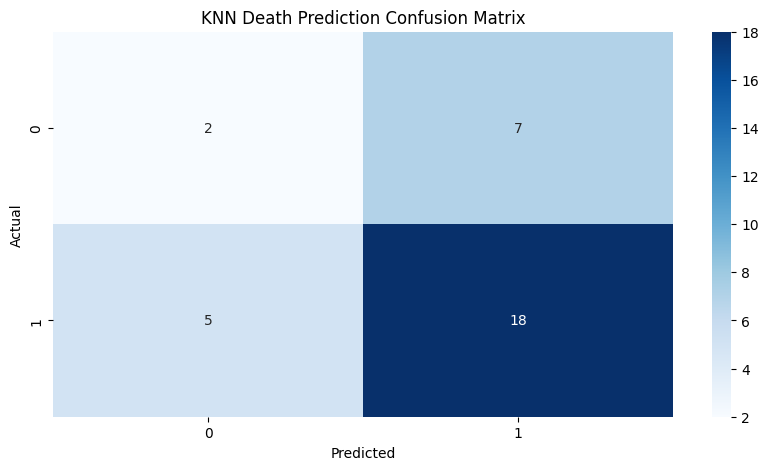

Starting training for ADA with GridSearchCV...
Best parameters for ADA are {'learning_rate': 1.0, 'n_estimators': 200}
Accuracy 0.625
F1 Score 0.75
Precision 0.72
Recall 0.782608695652174
roc-auc 0.5024154589371981


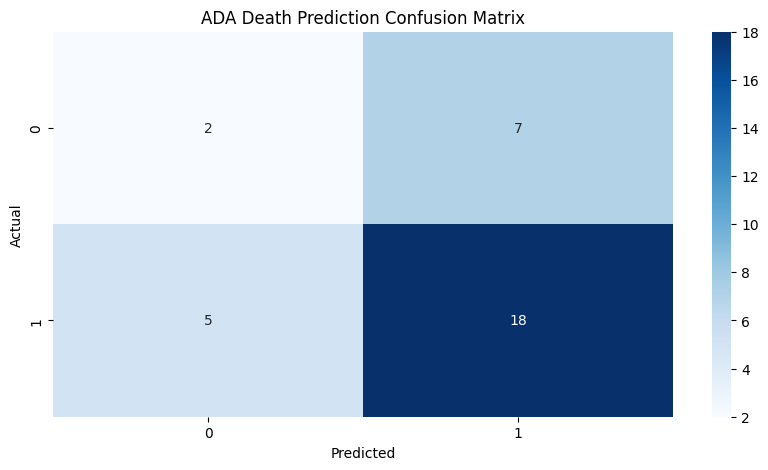

classification_models and results saved in ../models/bagging/aml/5-chunks
(159, 3842)
Starting training for SVM with GridSearchCV...
Best parameters for SVM are {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy 0.65625
F1 Score 0.7843137254901961
Precision 0.7142857142857143
Recall 0.8695652173913043
roc-auc 0.4903381642512078


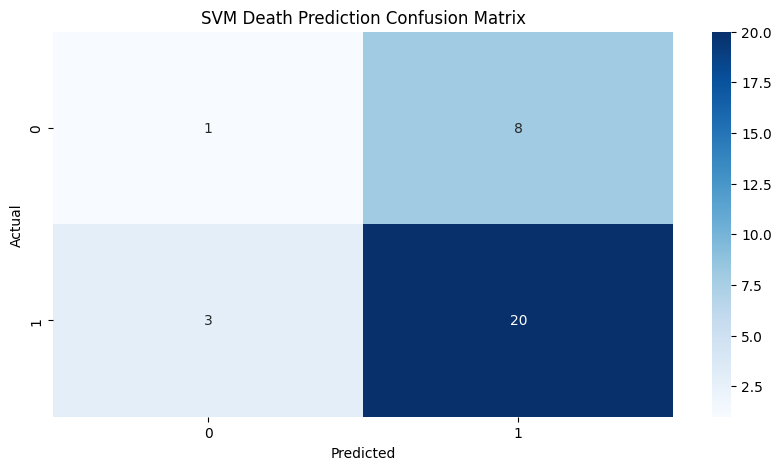

Starting training for RF with GridSearchCV...
Best parameters for RF are {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy 0.65625
F1 Score 0.7843137254901961
Precision 0.7142857142857143
Recall 0.8695652173913043
roc-auc 0.4903381642512078


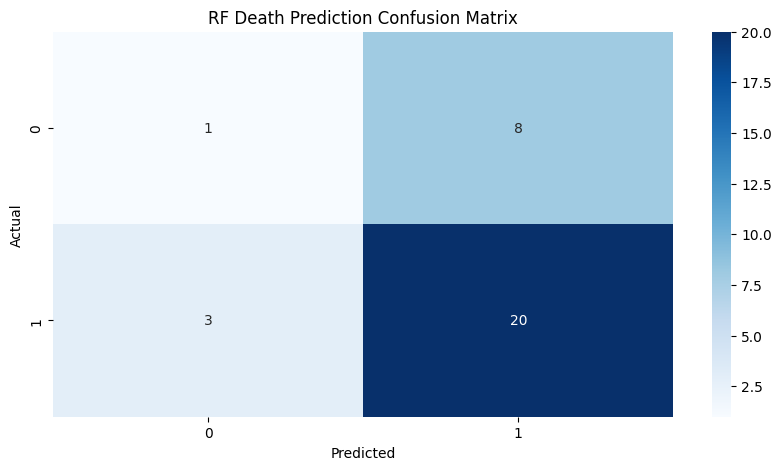

Starting training for KNN with GridSearchCV...
Best parameters for KNN are {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}
Accuracy 0.65625
F1 Score 0.7843137254901961
Precision 0.7142857142857143
Recall 0.8695652173913043
roc-auc 0.4903381642512078


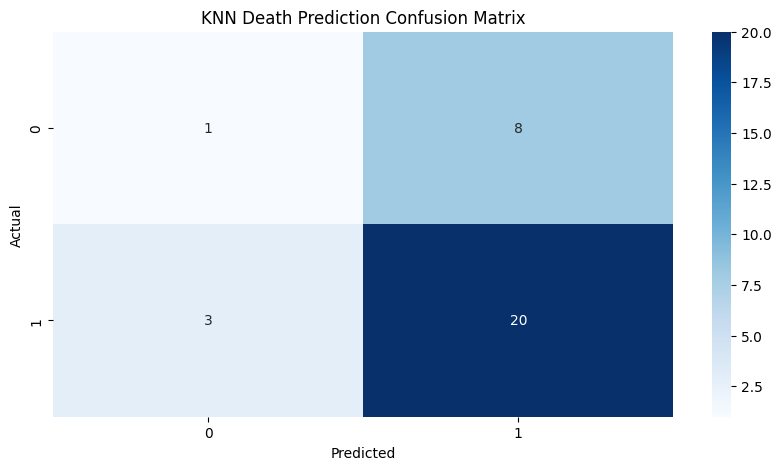

Starting training for ADA with GridSearchCV...
Best parameters for ADA are {'learning_rate': 1.0, 'n_estimators': 200}
Accuracy 0.65625
F1 Score 0.7843137254901961
Precision 0.7142857142857143
Recall 0.8695652173913043
roc-auc 0.4903381642512078


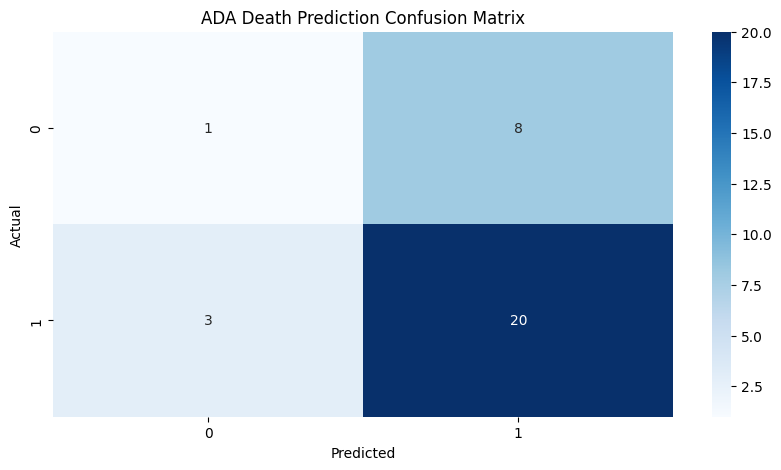

classification_models and results saved in ../models/bagging/aml/10-chunks
(159, 7682)
Starting training for SVM with GridSearchCV...
Best parameters for SVM are {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy 0.625
F1 Score 0.7692307692307693
Precision 0.6896551724137931
Recall 0.8695652173913043
roc-auc 0.43478260869565216


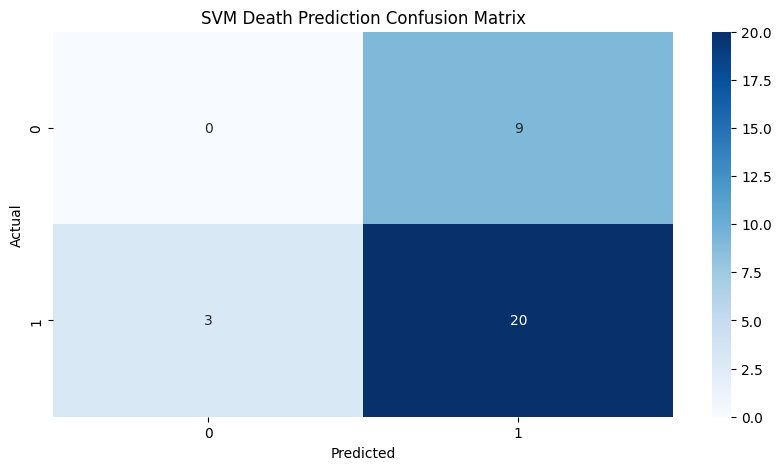

Starting training for RF with GridSearchCV...
Best parameters for RF are {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy 0.625
F1 Score 0.7692307692307693
Precision 0.6896551724137931
Recall 0.8695652173913043
roc-auc 0.43478260869565216


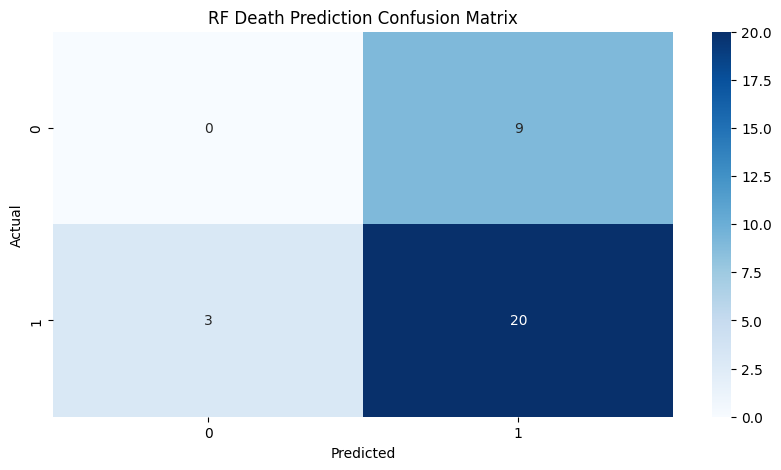

Starting training for KNN with GridSearchCV...
Best parameters for KNN are {'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'uniform'}
Accuracy 0.625
F1 Score 0.7692307692307693
Precision 0.6896551724137931
Recall 0.8695652173913043
roc-auc 0.43478260869565216


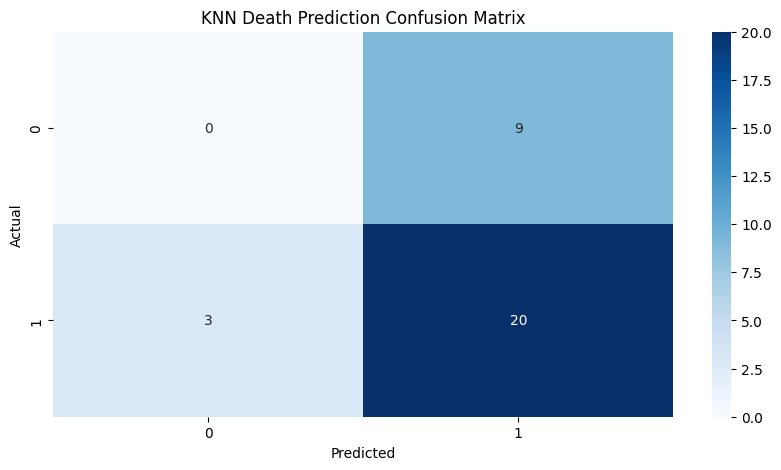

Starting training for ADA with GridSearchCV...
Best parameters for ADA are {'learning_rate': 1.0, 'n_estimators': 100}
Accuracy 0.625
F1 Score 0.7692307692307693
Precision 0.6896551724137931
Recall 0.8695652173913043
roc-auc 0.43478260869565216


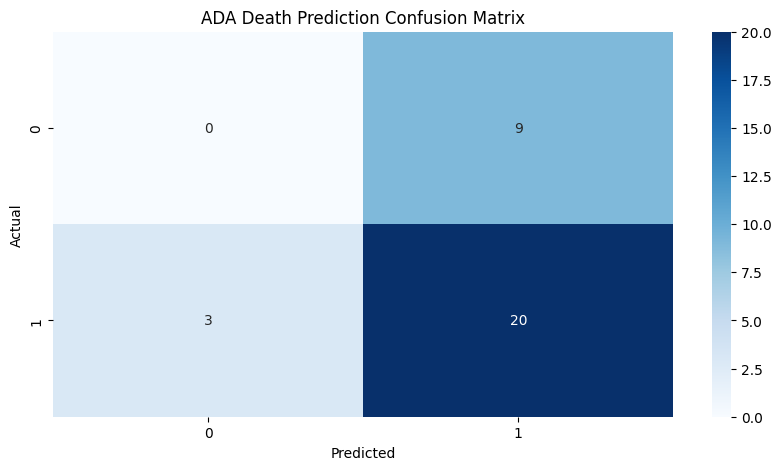

classification_models and results saved in ../models/bagging/aml/20-chunks
(159, 15362)


In [60]:
num_chunks = [3, 5, 10, 20]
for chunk in num_chunks:
    df = pd.read_csv(f"../embedding/embeddings/{chunk}-chunked_aml_embeddings.csv")
    feature_per_chunk = (df.shape[1] - 2) / chunk
    df.dropna(inplace=True)
    X = df.drop(
        ["Survival", "Death"],
        axis=1,
        inplace=False,
    )
    y = df["Death"]

    trainClassificationModel(
        X, y, f"../models/bagging/aml/{chunk}-chunks", chunk, bagging=True
    )
    print(df.shape)

In [4]:
# test chunking
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import clone
import pandas as pd

# Step 1: Generate or load your dataset
# Assuming `X` is the feature matrix and `y` is the target variable
df = pd.read_csv("../dataset/processed/aml/final_data.csv")
X = df.drop(
    ["Death", "Survival"], axis=1, inplace=False
)  # Simulated dataset with 11,000 features
y = df["Death"]  # Binary target variable


# Step 2: Divide dataset into feature chunks
def split_into_chunks(X, n_chunks):
    """Split feature matrix into n_chunks chunks."""
    chunk_size = X.shape[1] // n_chunks
    chunks = [X[:, i * chunk_size : (i + 1) * chunk_size] for i in range(n_chunks)]
    # Handle any remaining features
    if X.shape[1] % n_chunks != 0:
        chunks.append(X[:, n_chunks * chunk_size :])
    return chunks


n_chunks = 16  # Example: Divide features into 16 chunks
X_chunks = split_into_chunks(X, n_chunks)

# Step 3: Train-Test Split
X_train_chunks, X_test_chunks, y_train, y_test = train_test_split(
    X_chunks, y, test_size=0.2, random_state=42
)

# Step 4: Train base models on each feature chunk
base_models = [RandomForestClassifier(random_state=42) for _ in range(n_chunks)]
chunk_predictions_train = []
chunk_predictions_test = []

for i, model in enumerate(base_models):
    print(f"Training model for chunk {i + 1}/{n_chunks}...")
    # Train on the ith chunk
    model.fit(X_train_chunks[i], y_train)
    # Save predictions for meta-learning
    chunk_predictions_train.append(model.predict_proba(X_train_chunks[i])[:, 1])
    chunk_predictions_test.append(model.predict_proba(X_test_chunks[i])[:, 1])

# Step 5: Stack predictions for meta-learning
stacked_train = np.column_stack(chunk_predictions_train)
stacked_test = np.column_stack(chunk_predictions_test)

# Step 6: Train a meta-learner on stacked predictions
meta_learner = LogisticRegression(random_state=42)
meta_learner.fit(stacked_train, y_train)

# Step 7: Evaluate the ensemble model
final_predictions = meta_learner.predict(stacked_test)
accuracy = accuracy_score(y_test, final_predictions)
print(f"Ensemble model accuracy: {accuracy:.4f}")


InvalidIndexError: (slice(None, None, None), slice(0, 731, None))